In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.4.0 True
2.4.0
10.1
GCC 7.3


In [2]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class LotteDataset(CustomDataset):

    CLASSES = ('ID_gum', 'buttering', 'couque_coffee', 'chocopie', 'cidar', 
               'couque_white', 'coke', 'diget_ori', 'diget_choco', 'gumi_gumi', 
               'homerunball', 'jjolbyung_noodle', 'juicyfresh', 'jjolbyung_ori', 
               'spearmint', 'squid_peanut', 'samdasu', 'tuna', 'toreta', 
               'vita500', 'welchs', 'zec')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('JPEGImages', 'Annotations')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[1:]] for x in content]

            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

In [8]:
from mmcv import Config
cfg = Config.fromfile('./mmdetection/configs/retinanet/retinanet_r50_fpn_1x_coco.py')

In [9]:
from mmdet.apis import set_random_seed

cfg.dataset_type = 'LotteDataset'
cfg.data_root = 'lotte_data/'

cfg.data.test.type = 'LotteDataset'
cfg.data.test.data_root = 'lotte_data/'
cfg.data.test.ann_file = 'train.txt'
cfg.data.test.img_prefix = 'training/JPEGImages'

cfg.data.train.type = 'LotteDataset'
cfg.data.train.data_root = 'lotte_data/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/JPEGImages'

cfg.data.val.type = 'LotteDataset'
cfg.data.val.data_root = 'lotte_data/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/JPEGImages'

# num classes of the model in box head
cfg.model.bbox_head.num_classes = 22
cfg.work_dir = './tutorial_exps'

# original learning rate는 GPU가 8개이므로, 자신의 GPU의 개수에 맞게 변형
cfg.optimizer.lr = 0.02 / 8 # 한 개만 쓸거니까
cfg.log_config.interval = 10

cfg.evaluation.metric = 'mAP'
# set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# ㄴet seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='RetinaNet',
    pretrained='torchvision://resnet50',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        start_level=1,
        add_extra_convs='on_input',
        num_outs=5),
    bbox_head=dict(
        type='RetinaHead',
        num_classes=22,
        in_channels=256,
        stacked_convs=4,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            octave_base_scale=4,
            scales_per_octave=3,
            ratios=[0.5, 1.0, 2.0],
            strides=[8, 16, 32, 64, 128]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            ta

In [10]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# dataset 구축
datasets = [build_dataset(cfg.data.train)]

# detector 구축
model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
model.CLASSES = datasets[0].CLASSES

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

2020-09-28 11:29:07,202 - mmdet - INFO - load model from: torchvision://resnet50
2020-09-28 11:29:07,313 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2020-09-28 11:29:14,762 - mmdet - INFO - Start running, host: jmh@jmh-GE75-Raider-10SF, work_dir: /home/jmh/content/mmdetection_object_detection_demo/tutorial_exps
2020-09-28 11:29:14,762 - mmdet - INFO - workflow: [('train', 1)], max: 12 epochs
2020-09-28 11:29:24,584 - mmdet - INFO - Epoch [1][10/587]	lr: 4.746e-05, eta: 1:53:56, time: 0.972, data_time: 0.233, memory: 3009, loss_cls: 1.1409, loss_bbox: 0.6555, loss: 1.7964
2020-09-28 11:29:28,546 - mmdet - INFO - Epoch [1][20/587]	lr: 9.741e-05, eta: 1:20:06, time: 0.397, data_time: 0.014, memory: 3009, loss_cls: 1.1406, loss_bbox: 0.6648, loss: 1.8054
2020-09-28 11:29:32,544 - mmdet - INFO - Epoch [1][30/587]	lr: 1.474e-04, eta: 1:08:50, time: 0.398, data_time: 0.013, memory: 3009, loss_cls: 1.1411, l

2020-09-28 11:32:16,038 - mmdet - INFO - Epoch [1][430/587]	lr: 2.145e-03, eta: 0:46:26, time: 0.415, data_time: 0.016, memory: 3009, loss_cls: 0.6238, loss_bbox: 0.3810, loss: 1.0048
2020-09-28 11:32:19,907 - mmdet - INFO - Epoch [1][440/587]	lr: 2.195e-03, eta: 0:46:17, time: 0.389, data_time: 0.015, memory: 3009, loss_cls: 0.6245, loss_bbox: 0.3716, loss: 0.9961
2020-09-28 11:32:23,918 - mmdet - INFO - Epoch [1][450/587]	lr: 2.245e-03, eta: 0:46:09, time: 0.399, data_time: 0.013, memory: 3009, loss_cls: 0.6517, loss_bbox: 0.3544, loss: 1.0061
2020-09-28 11:32:27,781 - mmdet - INFO - Epoch [1][460/587]	lr: 2.295e-03, eta: 0:46:01, time: 0.388, data_time: 0.015, memory: 3009, loss_cls: 0.6821, loss_bbox: 0.3566, loss: 1.0387
2020-09-28 11:32:31,827 - mmdet - INFO - Epoch [1][470/587]	lr: 2.345e-03, eta: 0:45:55, time: 0.405, data_time: 0.013, memory: 3009, loss_cls: 0.6979, loss_bbox: 0.3671, loss: 1.0650
2020-09-28 11:32:35,763 - mmdet - INFO - Epoch [1][480/587]	lr: 2.395e-03, eta: 

2020-09-28 11:35:17,652 - mmdet - INFO - Epoch [2][300/587]	lr: 2.500e-03, eta: 0:41:39, time: 0.398, data_time: 0.013, memory: 3009, loss_cls: 0.3844, loss_bbox: 0.2165, loss: 0.6010
2020-09-28 11:35:21,514 - mmdet - INFO - Epoch [2][310/587]	lr: 2.500e-03, eta: 0:41:33, time: 0.386, data_time: 0.013, memory: 3009, loss_cls: 0.3822, loss_bbox: 0.2300, loss: 0.6121
2020-09-28 11:35:25,229 - mmdet - INFO - Epoch [2][320/587]	lr: 2.500e-03, eta: 0:41:27, time: 0.372, data_time: 0.013, memory: 3009, loss_cls: 0.3696, loss_bbox: 0.2141, loss: 0.5837
2020-09-28 11:35:29,133 - mmdet - INFO - Epoch [2][330/587]	lr: 2.500e-03, eta: 0:41:22, time: 0.390, data_time: 0.013, memory: 3009, loss_cls: 0.3783, loss_bbox: 0.2304, loss: 0.6086
2020-09-28 11:35:33,038 - mmdet - INFO - Epoch [2][340/587]	lr: 2.500e-03, eta: 0:41:17, time: 0.389, data_time: 0.013, memory: 3009, loss_cls: 0.3701, loss_bbox: 0.2083, loss: 0.5784
2020-09-28 11:35:36,823 - mmdet - INFO - Epoch [2][350/587]	lr: 2.500e-03, eta: 

2020-09-28 11:38:18,426 - mmdet - INFO - Epoch [3][170/587]	lr: 2.500e-03, eta: 0:38:01, time: 0.386, data_time: 0.013, memory: 3009, loss_cls: 0.2743, loss_bbox: 0.1782, loss: 0.4525
2020-09-28 11:38:22,573 - mmdet - INFO - Epoch [3][180/587]	lr: 2.500e-03, eta: 0:37:58, time: 0.413, data_time: 0.013, memory: 3009, loss_cls: 0.2595, loss_bbox: 0.1926, loss: 0.4521
2020-09-28 11:38:26,357 - mmdet - INFO - Epoch [3][190/587]	lr: 2.500e-03, eta: 0:37:53, time: 0.381, data_time: 0.015, memory: 3009, loss_cls: 0.2466, loss_bbox: 0.1892, loss: 0.4358
2020-09-28 11:38:30,505 - mmdet - INFO - Epoch [3][200/587]	lr: 2.500e-03, eta: 0:37:50, time: 0.413, data_time: 0.013, memory: 3009, loss_cls: 0.2899, loss_bbox: 0.1969, loss: 0.4868
2020-09-28 11:38:34,405 - mmdet - INFO - Epoch [3][210/587]	lr: 2.500e-03, eta: 0:37:45, time: 0.392, data_time: 0.015, memory: 3009, loss_cls: 0.2596, loss_bbox: 0.1718, loss: 0.4314
2020-09-28 11:38:38,333 - mmdet - INFO - Epoch [3][220/587]	lr: 2.500e-03, eta: 

2020-09-28 11:41:20,036 - mmdet - INFO - Epoch [4][40/587]	lr: 2.500e-03, eta: 0:34:46, time: 0.407, data_time: 0.015, memory: 3009, loss_cls: 0.1772, loss_bbox: 0.1661, loss: 0.3433
2020-09-28 11:41:23,890 - mmdet - INFO - Epoch [4][50/587]	lr: 2.500e-03, eta: 0:34:42, time: 0.385, data_time: 0.013, memory: 3009, loss_cls: 0.1566, loss_bbox: 0.1542, loss: 0.3108
2020-09-28 11:41:27,817 - mmdet - INFO - Epoch [4][60/587]	lr: 2.500e-03, eta: 0:34:38, time: 0.393, data_time: 0.013, memory: 3009, loss_cls: 0.1539, loss_bbox: 0.1475, loss: 0.3015
2020-09-28 11:41:31,525 - mmdet - INFO - Epoch [4][70/587]	lr: 2.500e-03, eta: 0:34:33, time: 0.371, data_time: 0.013, memory: 3009, loss_cls: 0.1791, loss_bbox: 0.1454, loss: 0.3245
2020-09-28 11:41:35,309 - mmdet - INFO - Epoch [4][80/587]	lr: 2.500e-03, eta: 0:34:28, time: 0.378, data_time: 0.013, memory: 3009, loss_cls: 0.1661, loss_bbox: 0.1506, loss: 0.3167
2020-09-28 11:41:39,237 - mmdet - INFO - Epoch [4][90/587]	lr: 2.500e-03, eta: 0:34:2

2020-09-28 11:44:16,583 - mmdet - INFO - Epoch [4][490/587]	lr: 2.500e-03, eta: 0:31:42, time: 0.393, data_time: 0.013, memory: 3009, loss_cls: 0.1153, loss_bbox: 0.1409, loss: 0.2562
2020-09-28 11:44:20,371 - mmdet - INFO - Epoch [4][500/587]	lr: 2.500e-03, eta: 0:31:37, time: 0.379, data_time: 0.013, memory: 3009, loss_cls: 0.1262, loss_bbox: 0.1514, loss: 0.2776
2020-09-28 11:44:24,291 - mmdet - INFO - Epoch [4][510/587]	lr: 2.500e-03, eta: 0:31:33, time: 0.390, data_time: 0.013, memory: 3009, loss_cls: 0.1465, loss_bbox: 0.1738, loss: 0.3203
2020-09-28 11:44:28,122 - mmdet - INFO - Epoch [4][520/587]	lr: 2.500e-03, eta: 0:31:29, time: 0.385, data_time: 0.015, memory: 3009, loss_cls: 0.1305, loss_bbox: 0.1573, loss: 0.2878
2020-09-28 11:44:32,100 - mmdet - INFO - Epoch [4][530/587]	lr: 2.500e-03, eta: 0:31:25, time: 0.398, data_time: 0.013, memory: 3009, loss_cls: 0.0995, loss_bbox: 0.1623, loss: 0.2618
2020-09-28 11:44:36,104 - mmdet - INFO - Epoch [4][540/587]	lr: 2.500e-03, eta: 

2020-09-28 11:47:17,776 - mmdet - INFO - Epoch [5][360/587]	lr: 2.500e-03, eta: 0:28:35, time: 0.398, data_time: 0.013, memory: 3009, loss_cls: 0.0715, loss_bbox: 0.1365, loss: 0.2080
2020-09-28 11:47:21,753 - mmdet - INFO - Epoch [5][370/587]	lr: 2.500e-03, eta: 0:28:31, time: 0.398, data_time: 0.015, memory: 3009, loss_cls: 0.0819, loss_bbox: 0.1366, loss: 0.2185
2020-09-28 11:47:25,683 - mmdet - INFO - Epoch [5][380/587]	lr: 2.500e-03, eta: 0:28:27, time: 0.393, data_time: 0.015, memory: 3009, loss_cls: 0.0721, loss_bbox: 0.1380, loss: 0.2101
2020-09-28 11:47:29,543 - mmdet - INFO - Epoch [5][390/587]	lr: 2.500e-03, eta: 0:28:23, time: 0.388, data_time: 0.015, memory: 3009, loss_cls: 0.0954, loss_bbox: 0.1390, loss: 0.2343
2020-09-28 11:47:33,473 - mmdet - INFO - Epoch [5][400/587]	lr: 2.500e-03, eta: 0:28:19, time: 0.391, data_time: 0.013, memory: 3009, loss_cls: 0.0915, loss_bbox: 0.1437, loss: 0.2352
2020-09-28 11:47:37,476 - mmdet - INFO - Epoch [5][410/587]	lr: 2.500e-03, eta: 

2020-09-28 11:50:19,315 - mmdet - INFO - Epoch [6][230/587]	lr: 2.500e-03, eta: 0:25:32, time: 0.388, data_time: 0.013, memory: 3009, loss_cls: 0.0621, loss_bbox: 0.1292, loss: 0.1912
2020-09-28 11:50:23,100 - mmdet - INFO - Epoch [6][240/587]	lr: 2.500e-03, eta: 0:25:28, time: 0.381, data_time: 0.015, memory: 3009, loss_cls: 0.0582, loss_bbox: 0.1399, loss: 0.1981
2020-09-28 11:50:27,119 - mmdet - INFO - Epoch [6][250/587]	lr: 2.500e-03, eta: 0:25:24, time: 0.400, data_time: 0.013, memory: 3009, loss_cls: 0.0663, loss_bbox: 0.1280, loss: 0.1942
2020-09-28 11:50:31,055 - mmdet - INFO - Epoch [6][260/587]	lr: 2.500e-03, eta: 0:25:20, time: 0.395, data_time: 0.015, memory: 3009, loss_cls: 0.0596, loss_bbox: 0.1300, loss: 0.1896
2020-09-28 11:50:34,912 - mmdet - INFO - Epoch [6][270/587]	lr: 2.500e-03, eta: 0:25:16, time: 0.384, data_time: 0.013, memory: 3009, loss_cls: 0.0512, loss_bbox: 0.1303, loss: 0.1815
2020-09-28 11:50:38,771 - mmdet - INFO - Epoch [6][280/587]	lr: 2.500e-03, eta: 

2020-09-28 11:53:20,312 - mmdet - INFO - Epoch [7][100/587]	lr: 2.500e-03, eta: 0:22:29, time: 0.381, data_time: 0.015, memory: 3009, loss_cls: 0.0788, loss_bbox: 0.1294, loss: 0.2082
2020-09-28 11:53:24,255 - mmdet - INFO - Epoch [7][110/587]	lr: 2.500e-03, eta: 0:22:25, time: 0.393, data_time: 0.013, memory: 3009, loss_cls: 0.0727, loss_bbox: 0.1240, loss: 0.1967
2020-09-28 11:53:28,078 - mmdet - INFO - Epoch [7][120/587]	lr: 2.500e-03, eta: 0:22:21, time: 0.384, data_time: 0.014, memory: 3009, loss_cls: 0.0694, loss_bbox: 0.1346, loss: 0.2039
2020-09-28 11:53:32,076 - mmdet - INFO - Epoch [7][130/587]	lr: 2.500e-03, eta: 0:22:17, time: 0.400, data_time: 0.013, memory: 3009, loss_cls: 0.0532, loss_bbox: 0.1206, loss: 0.1737
2020-09-28 11:53:35,932 - mmdet - INFO - Epoch [7][140/587]	lr: 2.500e-03, eta: 0:22:13, time: 0.386, data_time: 0.013, memory: 3009, loss_cls: 0.0712, loss_bbox: 0.1362, loss: 0.2074
2020-09-28 11:53:39,787 - mmdet - INFO - Epoch [7][150/587]	lr: 2.500e-03, eta: 

2020-09-28 11:56:17,014 - mmdet - INFO - Epoch [7][550/587]	lr: 2.500e-03, eta: 0:19:31, time: 0.383, data_time: 0.013, memory: 3009, loss_cls: 0.0545, loss_bbox: 0.1181, loss: 0.1726
2020-09-28 11:56:20,870 - mmdet - INFO - Epoch [7][560/587]	lr: 2.500e-03, eta: 0:19:27, time: 0.388, data_time: 0.015, memory: 3009, loss_cls: 0.0478, loss_bbox: 0.1295, loss: 0.1773
2020-09-28 11:56:24,650 - mmdet - INFO - Epoch [7][570/587]	lr: 2.500e-03, eta: 0:19:23, time: 0.378, data_time: 0.013, memory: 3009, loss_cls: 0.0380, loss_bbox: 0.1248, loss: 0.1627
2020-09-28 11:56:28,475 - mmdet - INFO - Epoch [7][580/587]	lr: 2.500e-03, eta: 0:19:19, time: 0.382, data_time: 0.013, memory: 3009, loss_cls: 0.0436, loss_bbox: 0.1197, loss: 0.1633
2020-09-28 11:56:37,331 - mmdet - INFO - Epoch [8][10/587]	lr: 2.500e-03, eta: 0:19:12, time: 0.595, data_time: 0.212, memory: 3009, loss_cls: 0.0632, loss_bbox: 0.1187, loss: 0.1819
2020-09-28 11:56:41,183 - mmdet - INFO - Epoch [8][20/587]	lr: 2.500e-03, eta: 0:

2020-09-28 11:59:17,992 - mmdet - INFO - Epoch [8][420/587]	lr: 2.500e-03, eta: 0:16:30, time: 0.395, data_time: 0.013, memory: 3009, loss_cls: 0.0636, loss_bbox: 0.1225, loss: 0.1861
2020-09-28 11:59:21,818 - mmdet - INFO - Epoch [8][430/587]	lr: 2.500e-03, eta: 0:16:26, time: 0.385, data_time: 0.015, memory: 3009, loss_cls: 0.0749, loss_bbox: 0.1256, loss: 0.2005
2020-09-28 11:59:25,675 - mmdet - INFO - Epoch [8][440/587]	lr: 2.500e-03, eta: 0:16:22, time: 0.386, data_time: 0.013, memory: 3009, loss_cls: 0.0480, loss_bbox: 0.1240, loss: 0.1720
2020-09-28 11:59:29,528 - mmdet - INFO - Epoch [8][450/587]	lr: 2.500e-03, eta: 0:16:18, time: 0.385, data_time: 0.013, memory: 3009, loss_cls: 0.0452, loss_bbox: 0.1195, loss: 0.1647
2020-09-28 11:59:33,603 - mmdet - INFO - Epoch [8][460/587]	lr: 2.500e-03, eta: 0:16:14, time: 0.407, data_time: 0.013, memory: 3009, loss_cls: 0.0468, loss_bbox: 0.1172, loss: 0.1639
2020-09-28 11:59:37,531 - mmdet - INFO - Epoch [8][470/587]	lr: 2.500e-03, eta: 

2020-09-28 12:02:18,391 - mmdet - INFO - Epoch [9][290/587]	lr: 2.500e-04, eta: 0:13:29, time: 0.399, data_time: 0.013, memory: 3009, loss_cls: 0.0313, loss_bbox: 0.1154, loss: 0.1467
2020-09-28 12:02:22,226 - mmdet - INFO - Epoch [9][300/587]	lr: 2.500e-04, eta: 0:13:25, time: 0.386, data_time: 0.015, memory: 3009, loss_cls: 0.0317, loss_bbox: 0.0949, loss: 0.1266
2020-09-28 12:02:26,203 - mmdet - INFO - Epoch [9][310/587]	lr: 2.500e-04, eta: 0:13:21, time: 0.395, data_time: 0.013, memory: 3009, loss_cls: 0.0355, loss_bbox: 0.0958, loss: 0.1314
2020-09-28 12:02:30,280 - mmdet - INFO - Epoch [9][320/587]	lr: 2.500e-04, eta: 0:13:17, time: 0.410, data_time: 0.016, memory: 3009, loss_cls: 0.0242, loss_bbox: 0.1005, loss: 0.1246
2020-09-28 12:02:34,358 - mmdet - INFO - Epoch [9][330/587]	lr: 2.500e-04, eta: 0:13:13, time: 0.408, data_time: 0.013, memory: 3009, loss_cls: 0.0347, loss_bbox: 0.0981, loss: 0.1329
2020-09-28 12:02:38,288 - mmdet - INFO - Epoch [9][340/587]	lr: 2.500e-04, eta: 

2020-09-28 12:05:20,299 - mmdet - INFO - Epoch [10][160/587]	lr: 2.500e-04, eta: 0:10:29, time: 0.382, data_time: 0.013, memory: 3009, loss_cls: 0.0282, loss_bbox: 0.1037, loss: 0.1319
2020-09-28 12:05:24,367 - mmdet - INFO - Epoch [10][170/587]	lr: 2.500e-04, eta: 0:10:25, time: 0.405, data_time: 0.013, memory: 3009, loss_cls: 0.0208, loss_bbox: 0.0984, loss: 0.1191
2020-09-28 12:05:28,145 - mmdet - INFO - Epoch [10][180/587]	lr: 2.500e-04, eta: 0:10:21, time: 0.380, data_time: 0.015, memory: 3009, loss_cls: 0.0344, loss_bbox: 0.1059, loss: 0.1403
2020-09-28 12:05:32,069 - mmdet - INFO - Epoch [10][190/587]	lr: 2.500e-04, eta: 0:10:17, time: 0.390, data_time: 0.013, memory: 3009, loss_cls: 0.0240, loss_bbox: 0.1014, loss: 0.1254
2020-09-28 12:05:36,068 - mmdet - INFO - Epoch [10][200/587]	lr: 2.500e-04, eta: 0:10:13, time: 0.400, data_time: 0.015, memory: 3009, loss_cls: 0.0318, loss_bbox: 0.1036, loss: 0.1354
2020-09-28 12:05:39,991 - mmdet - INFO - Epoch [10][210/587]	lr: 2.500e-04,

2020-09-28 12:08:21,598 - mmdet - INFO - Epoch [11][30/587]	lr: 2.500e-04, eta: 0:07:29, time: 0.392, data_time: 0.015, memory: 3009, loss_cls: 0.0362, loss_bbox: 0.0964, loss: 0.1326
2020-09-28 12:08:25,522 - mmdet - INFO - Epoch [11][40/587]	lr: 2.500e-04, eta: 0:07:25, time: 0.395, data_time: 0.015, memory: 3009, loss_cls: 0.0302, loss_bbox: 0.0964, loss: 0.1267
2020-09-28 12:08:29,418 - mmdet - INFO - Epoch [11][50/587]	lr: 2.500e-04, eta: 0:07:21, time: 0.388, data_time: 0.013, memory: 3009, loss_cls: 0.0334, loss_bbox: 0.0922, loss: 0.1256
2020-09-28 12:08:33,272 - mmdet - INFO - Epoch [11][60/587]	lr: 2.500e-04, eta: 0:07:17, time: 0.387, data_time: 0.015, memory: 3009, loss_cls: 0.0325, loss_bbox: 0.1003, loss: 0.1328
2020-09-28 12:08:37,196 - mmdet - INFO - Epoch [11][70/587]	lr: 2.500e-04, eta: 0:07:13, time: 0.390, data_time: 0.013, memory: 3009, loss_cls: 0.0244, loss_bbox: 0.0959, loss: 0.1204
2020-09-28 12:08:41,239 - mmdet - INFO - Epoch [11][80/587]	lr: 2.500e-04, eta: 

2020-09-28 12:11:18,337 - mmdet - INFO - Epoch [11][480/587]	lr: 2.500e-04, eta: 0:04:32, time: 0.385, data_time: 0.013, memory: 3009, loss_cls: 0.0171, loss_bbox: 0.0939, loss: 0.1109
2020-09-28 12:11:22,116 - mmdet - INFO - Epoch [11][490/587]	lr: 2.500e-04, eta: 0:04:28, time: 0.378, data_time: 0.013, memory: 3009, loss_cls: 0.0374, loss_bbox: 0.0954, loss: 0.1328
2020-09-28 12:11:26,084 - mmdet - INFO - Epoch [11][500/587]	lr: 2.500e-04, eta: 0:04:24, time: 0.397, data_time: 0.013, memory: 3009, loss_cls: 0.0220, loss_bbox: 0.0916, loss: 0.1136
2020-09-28 12:11:29,862 - mmdet - INFO - Epoch [11][510/587]	lr: 2.500e-04, eta: 0:04:20, time: 0.376, data_time: 0.013, memory: 3009, loss_cls: 0.0216, loss_bbox: 0.0978, loss: 0.1194
2020-09-28 12:11:33,714 - mmdet - INFO - Epoch [11][520/587]	lr: 2.500e-04, eta: 0:04:16, time: 0.387, data_time: 0.015, memory: 3009, loss_cls: 0.0271, loss_bbox: 0.0886, loss: 0.1157
2020-09-28 12:11:37,782 - mmdet - INFO - Epoch [11][530/587]	lr: 2.500e-04,

2020-09-28 12:14:18,819 - mmdet - INFO - Epoch [12][350/587]	lr: 2.500e-05, eta: 0:01:33, time: 0.400, data_time: 0.013, memory: 3009, loss_cls: 0.0291, loss_bbox: 0.0891, loss: 0.1182
2020-09-28 12:14:22,894 - mmdet - INFO - Epoch [12][360/587]	lr: 2.500e-05, eta: 0:01:29, time: 0.408, data_time: 0.013, memory: 3009, loss_cls: 0.0231, loss_bbox: 0.0965, loss: 0.1195
2020-09-28 12:14:26,969 - mmdet - INFO - Epoch [12][370/587]	lr: 2.500e-05, eta: 0:01:25, time: 0.405, data_time: 0.013, memory: 3009, loss_cls: 0.0218, loss_bbox: 0.0911, loss: 0.1130
2020-09-28 12:14:30,871 - mmdet - INFO - Epoch [12][380/587]	lr: 2.500e-05, eta: 0:01:21, time: 0.392, data_time: 0.015, memory: 3009, loss_cls: 0.0228, loss_bbox: 0.0942, loss: 0.1170
2020-09-28 12:14:34,947 - mmdet - INFO - Epoch [12][390/587]	lr: 2.500e-05, eta: 0:01:17, time: 0.405, data_time: 0.013, memory: 3009, loss_cls: 0.0243, loss_bbox: 0.0927, loss: 0.1170
2020-09-28 12:14:38,877 - mmdet - INFO - Epoch [12][400/587]	lr: 2.500e-05,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 829/829, 11.5 task/s, elapsed: 72s, ETA:     0s

2020-09-28 12:17:08,979 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| ID_gum           | 300 | 2801 | 0.993  | 0.987 |
| buttering        | 232 | 3000 | 0.983  | 0.975 |
| couque_coffee    | 394 | 3022 | 0.985  | 0.946 |
| chocopie         | 307 | 2515 | 0.997  | 0.989 |
| cidar            | 346 | 2419 | 0.997  | 0.994 |
| couque_white     | 346 | 3673 | 0.983  | 0.930 |
| coke             | 364 | 2351 | 0.992  | 0.987 |
| diget_ori        | 347 | 2329 | 0.997  | 0.972 |
| diget_choco      | 431 | 2317 | 0.993  | 0.983 |
| gumi_gumi        | 295 | 2019 | 0.993  | 0.993 |
| homerunball      | 302 | 3756 | 0.993  | 0.980 |
| jjolbyung_noodle | 339 | 2737 | 0.997  | 0.991 |
| juicyfresh       | 372 | 2680 | 0.995  | 0.977 |
| jjolbyung_ori    | 370 | 3291 | 0.989  | 0.976 |
| spearmint        | 267 | 2416 | 0.989  | 0.945 |
| squid_peanut     | 339 | 2374 | 1.000 

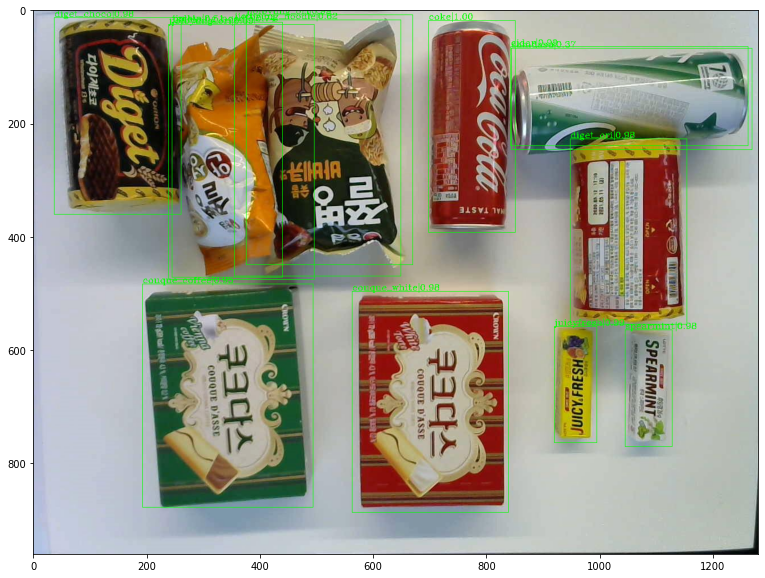

In [11]:
from mmdet.apis import inference_detector, show_result_pyplot
img = mmcv.imread('lotte_data/training/JPEGImages/0426.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

In [12]:
torch.save(model.state_dict(), 'state_dicts/RetinaNet_model_state_dict')